# Expectation-Maximization-Implementation
    Implementing EM Algorithm on noisy data-sets.
    Author: Sarvesh Thakur
    Course: CMSC422 - Introduction to Machine Learning

### Problem Statement
   The purpose of this problem is to implement the Expectation-Maximization algorithm for the problem of grouping points into lines. That is, we assume that we are given a set of points, and we want to find two lines that explain them. In the expectation step, we find the line that minimizes the weighted sum of squares distance from points to
    lines. The variance is estimated using the distance between each line and the points. In the maximization step we assign (probabilistically) each point to each line based on its distance to the lines.

   1. Line Fitting (20 points) Write a function that fits a line to data. Note that Weiss describes a method for doing this using weighted least squares, which essentially only looks at error in the y direction. This fits the examples below,in which noise is added to the y coordinate. If you are interested, you can also implement, for a small amount of extra credit, a total least squares method, that takes account of the Euclidean distance between each point and the line, and see what difference this makes. You will have to do a little research to see how this works. Test your function with the following set of points:

   (i) x=0:0.05:1; y=2*x+1
    (ii) x=0:0.05:1; y=2*x+1+0.1*randn(size(x))
    (iii) x=0:0.05:1; y=(abs(x-0.5) < 0.25).*(x+1)+(abs(x-0.5) >=0.25).*(-x);

   In all cases plot the data and the best fitting lines.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import math

### 0. Generate the Dataset

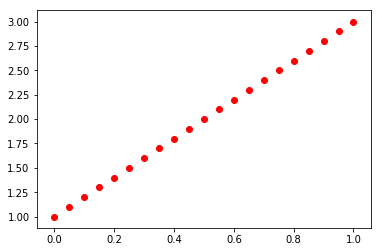

In [2]:
# Creating Datasets
x = np.round(np.arange(0, 1.05, 0.05), 3)

# data set 1
y1 = 2*x + 1
dataset1 = list(zip(x, y1))

# Visualize
plt.scatter(*zip(*dataset1), color='red')
plt.show()

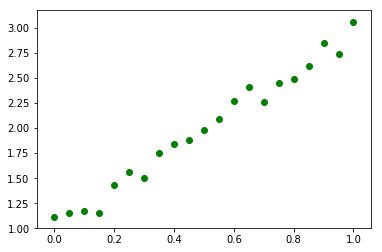

In [618]:
# data set 2
y2 = np.round(2*x + 1 + 0.1*np.random.normal(0,1,len(x)), 3)
dataset2 = list(zip(x, y2))

# Visualize
plt.scatter(*zip(*dataset2), color='green')
plt.show()

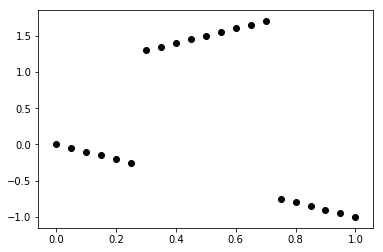

In [617]:
# data set 3
y3 = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x)
dataset3 = list(zip(x, y3))

# Visualize
plt.scatter(*zip(*dataset3), color='black')
plt.show()

## Part 1. Line Fitting (20 Points)

In [5]:
def get_params(p1, p2):
    # p1 and p2(tuples) are points through which
    # we fit a line
    # @returns param: slope and offset for mx + by + c = 0
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    if x1 != x2: # if slope is not infinite
        m = (y2-y1)/(x2-x1)
        c = (y1*x2 - y2*x1)/(x2-x1)
        b = -1
    else:
        m = 1
        c = 0
        b = -x1
    params = [m, b, c]
    return params

# get_params((0,1), (1,3))

def error_y(params, dataset):
    # @return error for a fitted line on a dataset
    # dataset is a list of tuples, which each tuple being
    # a coordinate
    error = 0;
    m, b, c = params
    for point in dataset:
        xi, yi = point[0], point[1]
        error += math.pow((yi + (m*xi + c)/b),2)
    return error
        
# error_y([2,-1,1], [(0,1), (1,3), (-1,-1)])

In [6]:
def fitLineRANSAC(dataset, iterations = 100):
    # returns params for best fitted line for the dataset
    # dataset is a list of tuples, which each tuple being
    # a coordinate
    param_error = dict()
    for count in range(int(iterations)):
        # randomly select two points from the list
        p1, p2 = random.sample(dataset, 2)
        # find the line parameters for line passing through them
        params = get_params(p1, p2)
        # calculate error for the model
        error = error_y(params, dataset)
        # store the error for the model
        param_error[tuple(params)] = error
    best_model = min(param_error, key=param_error.get)
    least_error = param_error[best_model]
    return best_model, least_error

def fitLineLeastSquares(dataset):
    N = len(dataset) # totalPoints
    dataset = np.array(dataset)
    X, Y = dataset[:,0], dataset[:,1]
    m = (N*(np.sum(X*Y)) - np.sum(X)*np.sum(Y))/(N*np.sum(X*X) - np.sum(X)*np.sum(X))
    c = (np.sum(Y) - m*np.sum(X))/N
    params = [m, -1, c]
    error = error_y(params, dataset)
    return params, error

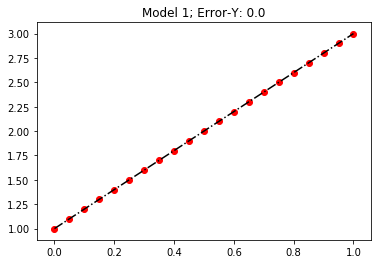

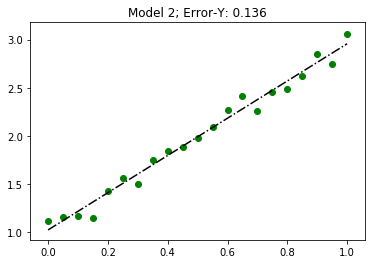

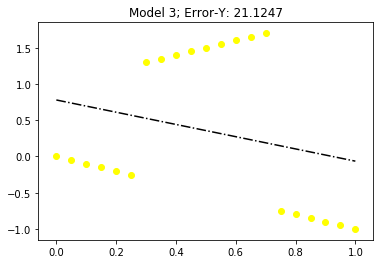

In [723]:
no_of_datapoints = len(dataset1)
max_iterations = no_of_datapoints*(no_of_datapoints-1)/2;

# Model 1
modelOne, errorOne = fitLineLeastSquares(dataset1)
plt.scatter(*zip(*dataset1), color='red')
m, b, c = modelOne
x1 = np.array([lis[0] for lis in dataset1])
y1 = -(m*x1+c)/b
plt.plot(x1, y1, linestyle='-.', color='black')
plt.title('Model 1' + '; Error-Y: ' + str(np.round(errorOne, 4)))
plt.show()

# Model 2
modelTwo, errorTwo = fitLineLeastSquares(dataset2)
plt.scatter(*zip(*dataset2), color='green')
m, b, c = modelTwo
x2 = np.array([lis[0] for lis in dataset2])
y2 = -(m*x2+c)/b
plt.plot(x2, y2, linestyle='-.', color='black')
plt.title('Model 2' + '; Error-Y: ' + str(np.round(errorTwo, 4)))
plt.show()

# Model 3
modelThree, errorThree = fitLineLeastSquares(dataset3)
plt.scatter(*zip(*dataset3), color='yellow')
m, b, c = modelThree
x3 = np.array([lis[0] for lis in dataset3])
y3 = -(m*x3+c)/b
plt.plot(x3, y3, linestyle='-.', color='black')
plt.title('Model 3' + '; Error-Y: ' + str(np.round(errorThree, 4)))
plt.show()

## Part 2: Expectation - Maximization Step

**2. E-M (80 points) Write a function that estimates the parameters of two lines using E-M. It should get as input vectors x,y and return (a1,b1,c1), (a2,b2,c2) the parameters of the two lines as well as the weight vectors w_1 and w_2. (Set the free parameter in Eq. (2) and (3), sigma^2=0.1.) You must figure out how to initialize E-M appropriately, and how to set other parameters, if any. You should be able to manage things to that the algorithm converges to a reasonable answer.**

In [626]:
def generate_random_param(dataset):
    # Generates 2 random points from the sample space.
    # @dataset is a list of tuples of coordinates
    # @return params for line passing through that point.
    
    if isinstance(dataset, np.ndarray) is False:
        dataset = np.array(dataset)
    
    x, y = dataset[:,0], dataset[:,1]
    min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)
    
    # generate random points
    p1 = random.random()*(max_x - min_x)+min_x, random.random()*(max_y - min_y)+min_y
    p2 = random.random()*(max_x - min_x)+min_x, random.random()*(max_y - min_y)+min_y
    
    return get_params(p1, p2)# Get param    

In [651]:
def assignClass(params, dataset, sigma=0.01):
    # params = [[m1, b1, c1], [m2, b2, c2]]
    [[m1, b1, c1], [m2, b2, c2]] = params
    
    if isinstance(dataset, np.ndarray) is False:
        datasetArr = np.array(copy.deepcopy(dataset))
    else:
        datasetArr = copy.deepcopy(dataset)
    
    X, Y = datasetArr[:,0], datasetArr[:,1]
    
    # Calculate Residuals
    r1, r2 = m1*X + c1 - Y, m2*X + c2 - Y
    
    # Calculate Weights
    s1, s2 = np.exp(-np.power(r1/sigma, 2)), np.exp(-np.power(r2/sigma, 2))
    w1, w2 = s1/(s1+s2), s2/(s1+s2)

    # Not a Number considerations
    NAN1, NAN2 = np.isnan(w1), np.isnan(w2)
    w1[NAN1], w2[NAN2] = 0.5, 0.5
    weights = [w1, w2]
    
    # Assign Class
    pointClassArray = w1<w2
    pointClassArray = pointClassArray + 1
    pointClass = {tuple(datasetArr[i]): pointClassArray[i] for i in range(len(pointClassArray))} 
    
    return weights, pointClass

def didConverge(params_old, params_new):
    # params_old: [param1_old:[m1_o, -1, c1_o], param2_old:[m2_o, -1, c2_o]]
    # params_new: [param1_new, param2_new]
    # returns boolean if the algorithm converges
    param1_old, param2_old = params_old
    param1_new, param2_new = params_new
    
    m1_o, _, c1_o = param1_old
    m2_o, _, c2_o = param2_old
    
    m1_n, _, c1_n = param1_new
    m2_n, _, c2_n = param2_new
    
    if abs(m1_o-m1_n)<0.05 and abs(m2_o-m2_n)<0.05 and abs(c1_o-c1_n)<0.05 and abs(c2_o-c2_n)<0.05:
        return True
    else:
        return False

In [724]:
def plotLines(params, dataset):
    plt.figure(figsize=(6,4))
    plt.scatter(*zip(*dataset), color='red')
    
    model1, model2 = params
    m1, b1, c1 = model1
    x3 = np.array([lis[0] for lis in dataset])
    y3_1 = -(m1*x3+c1)/b1
    plt.plot(x3, y3_1, linestyle='-.', color='black')

    m2, b2, c2 = model2
    y3_2 = -(m2*x3+c2)/b2
    plt.plot(x3, y3_2, linestyle='-.', color='black')

    plt.title('EM Model')
    plt.show()
    
def plotWeights(weights, dataset):
    w1, w2 = weights
    x = np.array([lis[0] for lis in dataset])
    
    plt.figure(figsize=(6,4))
    
    plt.subplot(121)
    plt.scatter(x, w1)
    
    plt.subplot(122)
    plt.scatter(x, w2)
    
    plt.suptitle('Weight Distribution - W1(Left) W2(Right)')
    plt.show()


In [725]:
def EM(dataset, sigma=0.1, iterations=100):
    
    ### Initialization ###
    # Random Param Values for 2 models 
    params_old = [[0,-1, 0],[0,-1,0]]

    param1_new = generate_random_param(dataset)
    param2_new = generate_random_param(dataset)
    params_new = [param1_new, param2_new]
    
    ### Iterate Till Convergence ###
    count = 0
    while didConverge(params_old, params_new) == False and count < iterations:
        count += 1
#         print("Did Converge?", didConverge(params_old, params_new), "Iteration: ", count)

        params_old = params_new
        
        # Expectation Step: Get the Weights for each line model
        sigma_val = copy.deepcopy(sigma)
        weights, pointsClass = assignClass(params_new, dataset, sigma_val)
        
        # Maximization Step
        w1, w2 = weights
        
        dataset = np.array(dataset)
        X, Y = dataset[:,0], dataset[:,1]
        
        # solving WLS for line 1 parameters
        A1 = np.matrix([[np.sum(w1*np.power(X,2)), np.sum(w1*X)], [np.sum(w1*X), np.sum(w1)] ])
        B1 = np.matrix([[np.sum(w1*X*Y)], [np.sum(w1*Y)]])
        A1_inv = np.linalg.inv(A1)
        param1 = np.matmul(A1_inv, B1)
        m1, c1 = np.asscalar(param1[0][0]), np.asscalar(param1[1][0])
        param1_new = [np.round(m1, 3), -1, np.round(c1, 3)] # Formatting
#         print("Line1: ",param1_new)
        
        # Solving WLS for Line 2 Parameters
        A2 = np.matrix([[np.sum(w2*np.power(X,2)), np.sum(w2*X)], [np.sum(w2*X), np.sum(w2)] ])
        B2 = np.matrix([[np.sum(w2*X*Y)], [np.sum(w2*Y)]])
        A2_inv = np.linalg.inv(A2)

        param2 = np.matmul(A2_inv, B2)
        m2, c2 = np.asscalar(param2[0][0]), np.asscalar(param2[1][0])
        param2_new = [np.round(m2, 3), -1, np.round(c2, 3)] # Formatting
#         print("Line2:",param2_new)
        
        
        params_new = [param1_new, param2_new]
#         print('Old: ', params_old)
#         print('New: ', params_new)

        # Plot Weights and Current Models
        plotLines(params_new, dataset)
        plotWeights(weights, dataset)
        
    weights, pointsClass = assignClass(params_new, dataset, sigma_val)
    print("EM Converged after {} iterations".format(count))
    return params_new, weights, pointsClass

**a. Test your function on the data in part (iii) of the previous question. Plot the data and the two fitted lines  as estimated after each of the first five iterations. Also, show in separate plots the membership vectors after every iteration.**

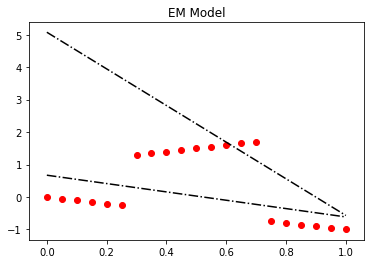

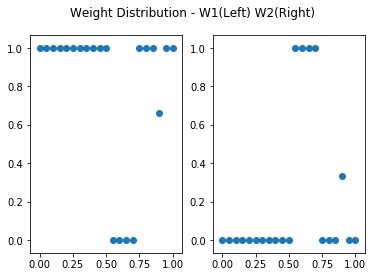

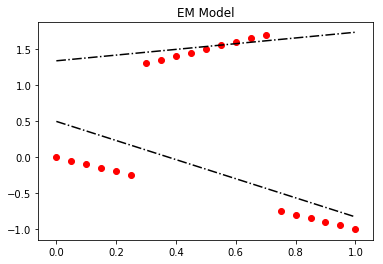

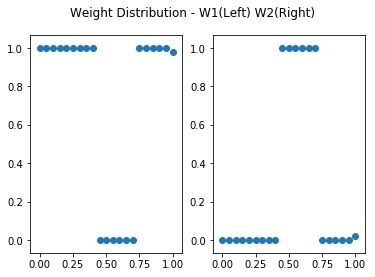

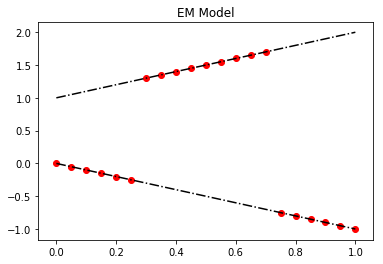

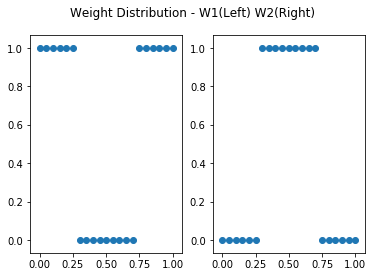

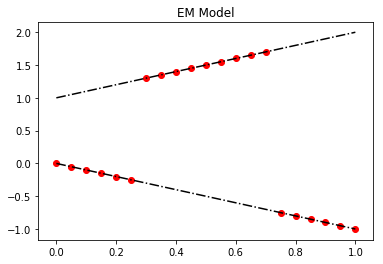

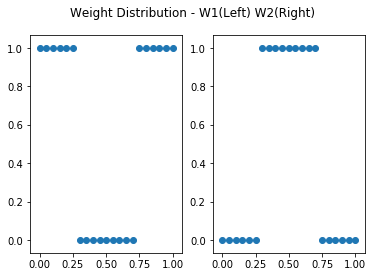

EM Converged after 4 iterations


In [728]:
models, weights, pointsClass = EM(dataset3, sigma=0.1, iterations=100)

**b. Experiment with adding Gaussian noise to the y coordinates. How much noise can you add before the algorithm breaks? Describe your experiment and illustrate with appropriate plot(s).**

### Experiment 1 NoiseLevel = 0.2

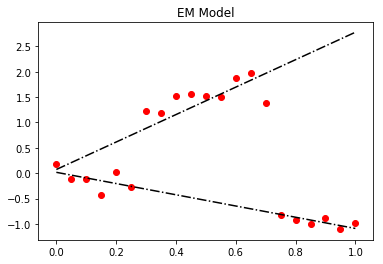

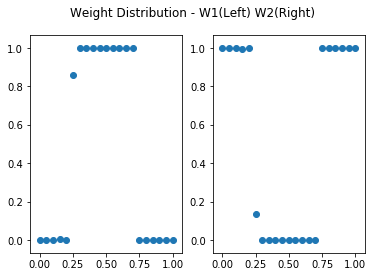

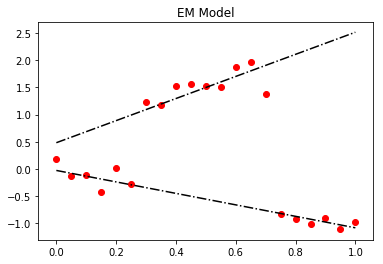

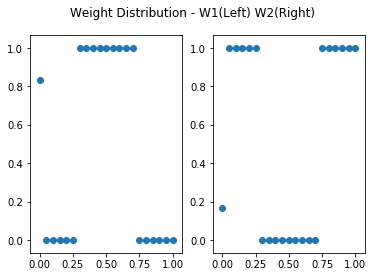

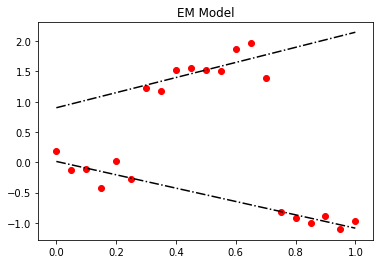

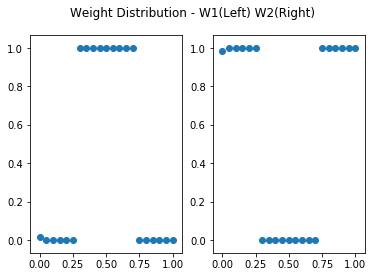

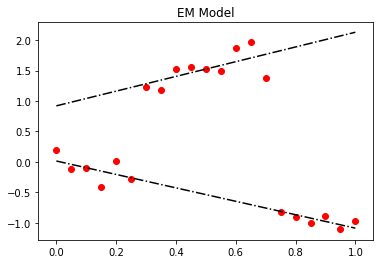

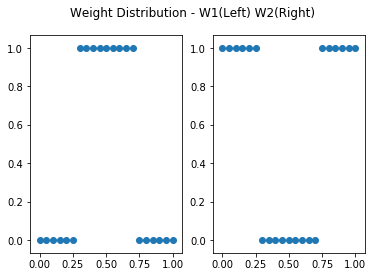

EM Converged after 4 iterations


In [741]:
# Experimenting with Noise

# Experiment 1
noiseLevel = 0.2

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)

### Experiment 2 NoiseLevel = 0.4

/home/detwieller/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


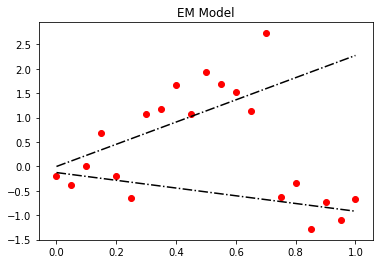

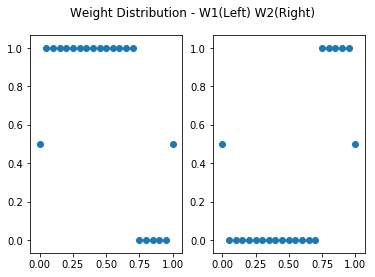

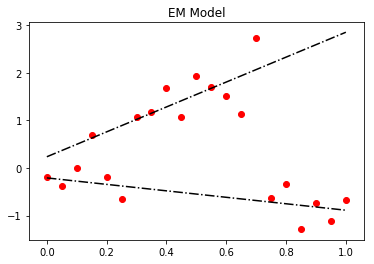

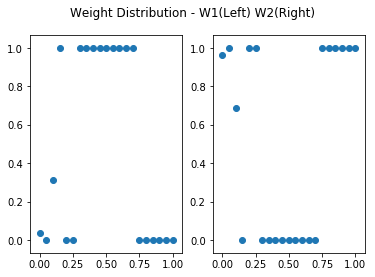

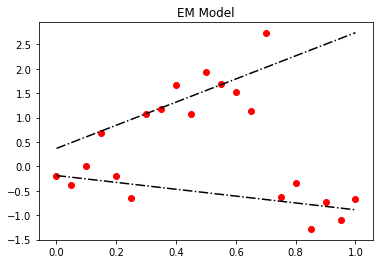

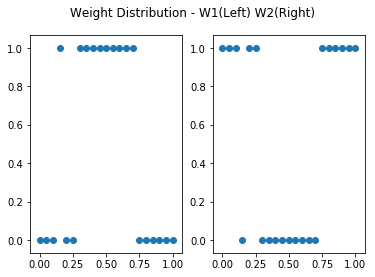

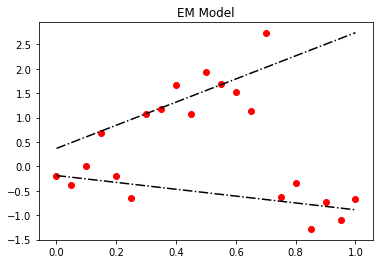

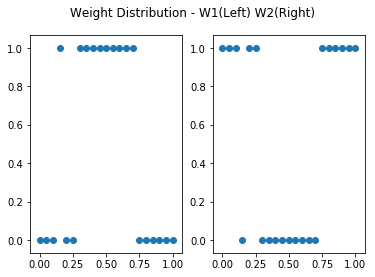

EM Converged after 4 iterations


In [738]:
# Experimenting with Noise

# Experiment 2
noiseLevel = 0.4

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)

### Experiment 3 NoiseLevel = 0.6

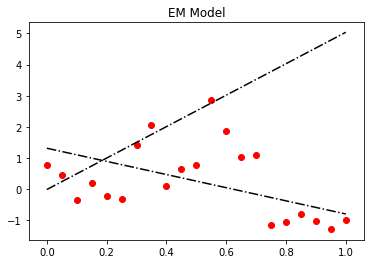

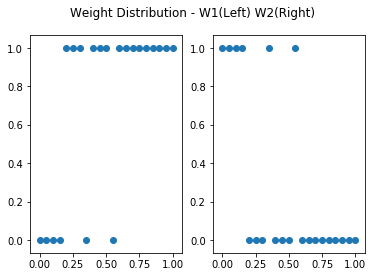

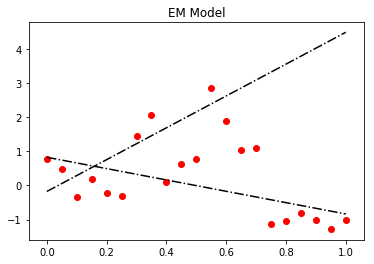

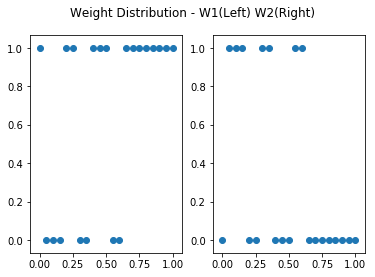

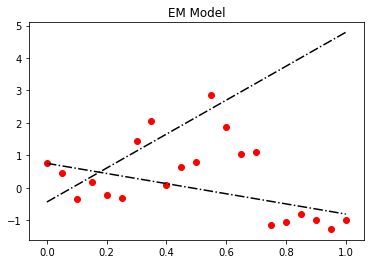

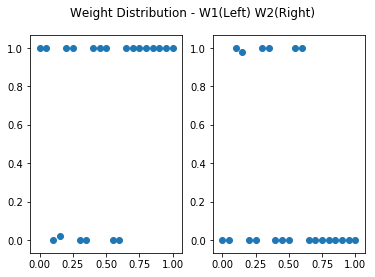

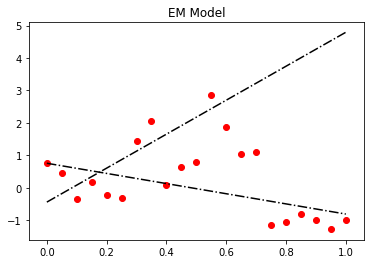

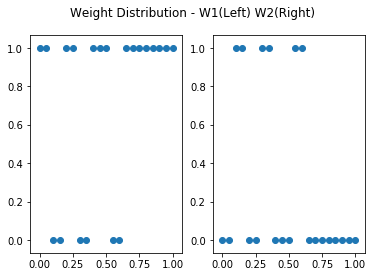

EM Converged after 4 iterations


In [743]:
# Experimenting with Noise

# Experiment 3
noiseLevel = 0.6

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)

### Experiment 4 NoiseLevel = 0.8

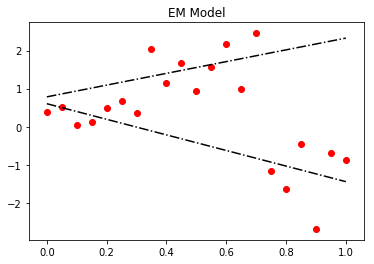

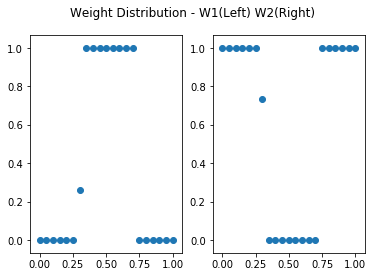

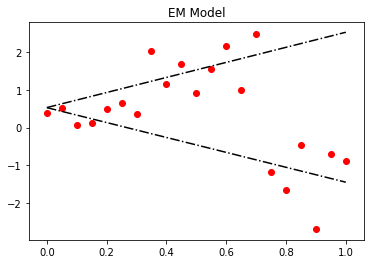

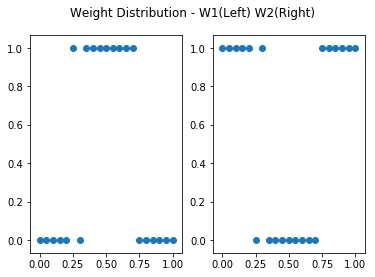

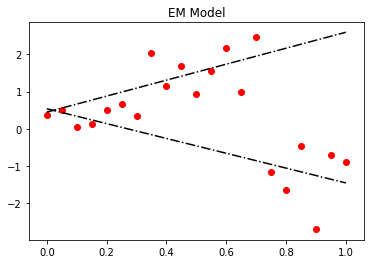

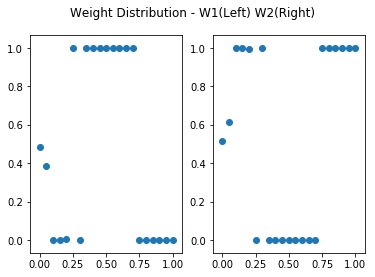

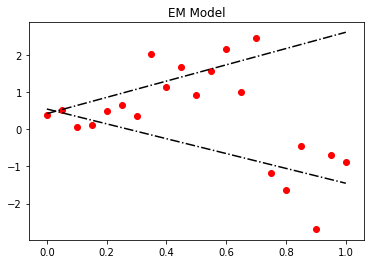

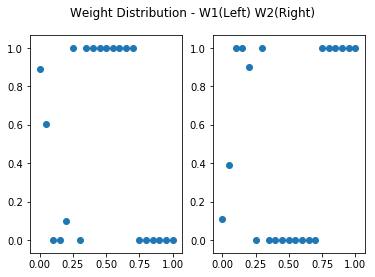

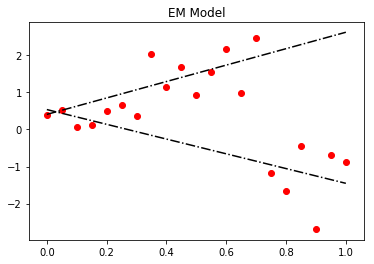

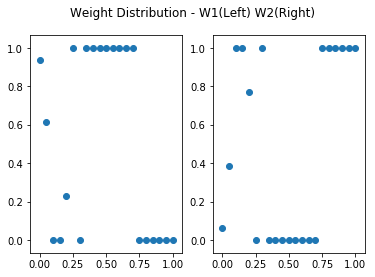

EM Converged after 5 iterations


In [744]:
# Experimenting with Noise

# Experiment 4
noiseLevel = 0.8

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)

### Experiment 5 NoiseLevel = 1.0

/home/detwieller/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


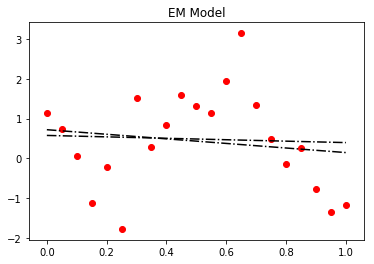

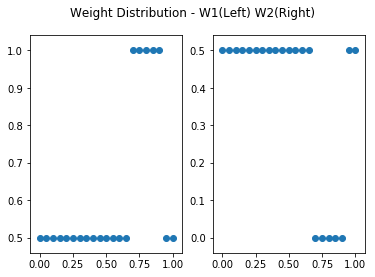

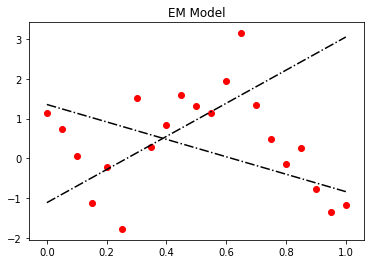

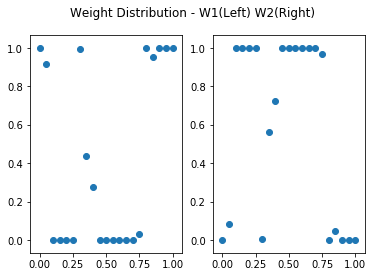

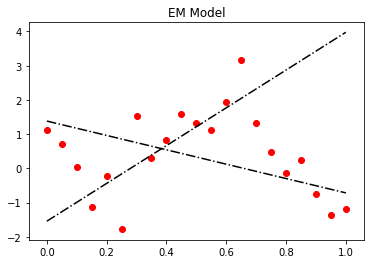

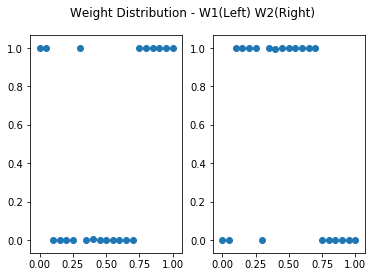

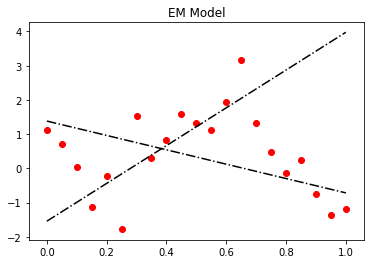

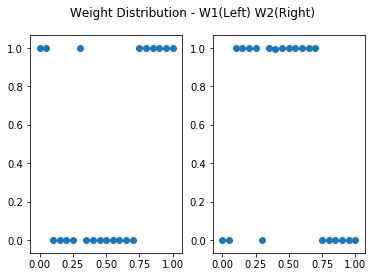

EM Converged after 4 iterations
[[-2.1, -1, 1.382], [5.523, -1, -1.545]]


In [746]:
# Experimenting with Noise

# Experiment 5
noiseLevel = 1.0

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)
print(models)

### Experiment 6 NoiseLevel = 2

/home/detwieller/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


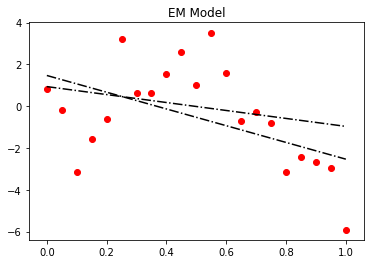

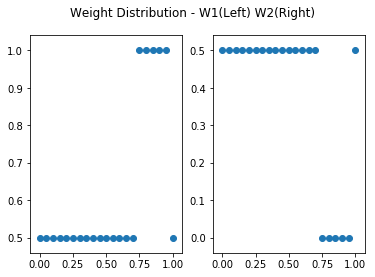

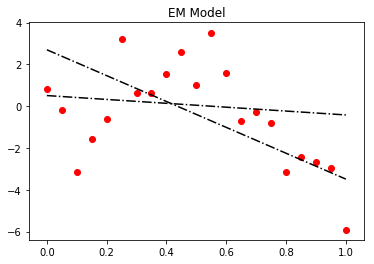

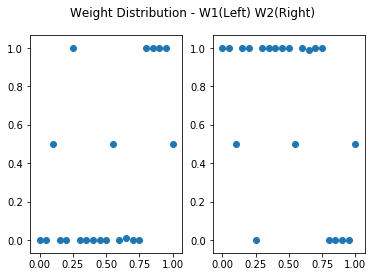

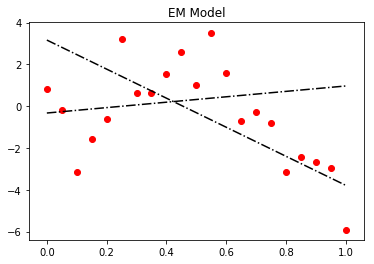

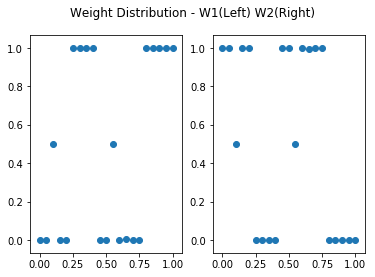

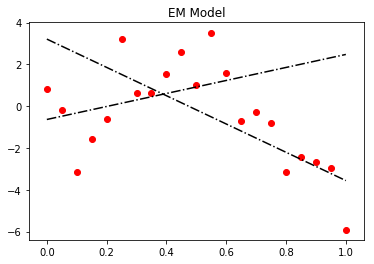

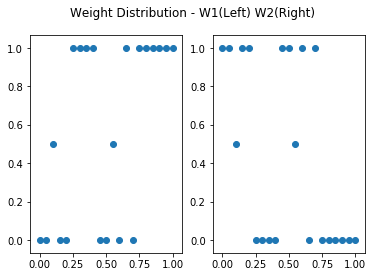

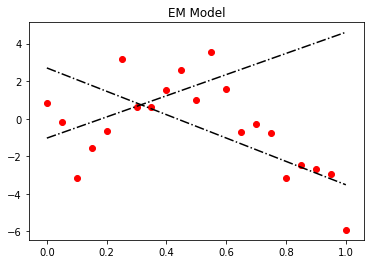

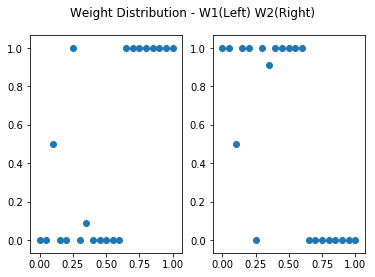

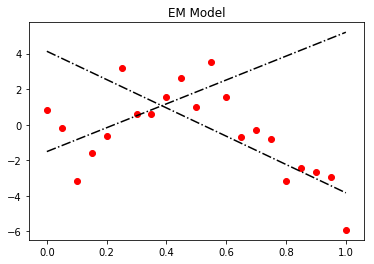

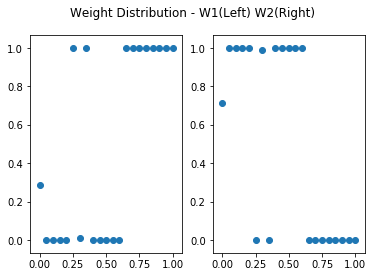

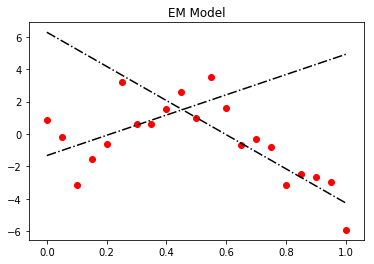

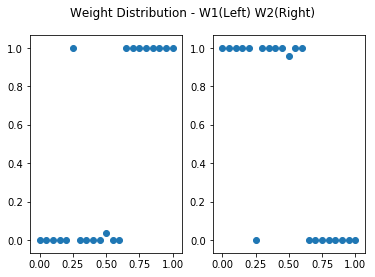

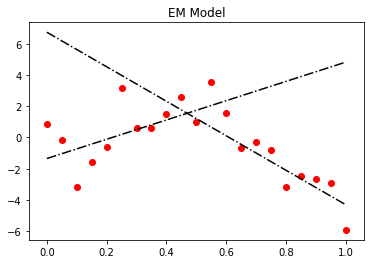

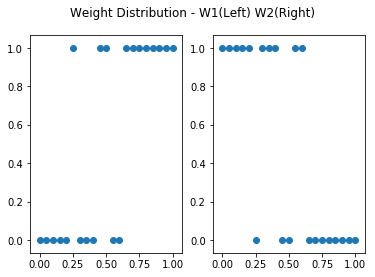

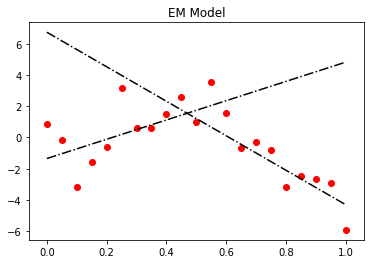

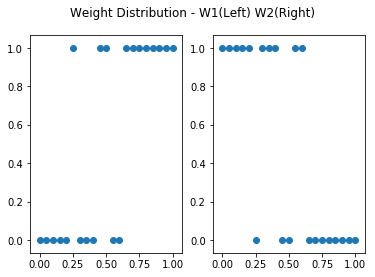

EM Converged after 9 iterations
[[-11.052, -1, 6.739], [6.177, -1, -1.349]]


In [750]:
# Experimenting with Noise

# Experiment 6
noiseLevel = 2

x = np.round(np.arange(0, 1.05, 0.05), 3)
y = (np.abs(x-0.5) < 0.25)*(x+1) + (np.abs(x-0.5) >= 0.25)*(-x) + noiseLevel*np.random.normal(0,1,len(x))
NoisyDataset = list(zip(x, y))

models, weights, pointsClass = EM(NoisyDataset, sigma=0.1, iterations=100)
print(models)

### Result Part(b)


**1) Algorithm seems to do a fairly well job even after adding very significant noise to the y-coordinates.**

**2) It does good job in producing similar sloped trend lines for noiseLevel of 0.5*np.random.normal(0,1,len(x)). It separates the points into two classes appropriately.(Till Experiment 2)**

**3) After Experiment 2, i.e. NoiseLevel>0.6 for NoiseLevel*np.random.normal(0,1,len(x)), the offset for one of the model changes considerably. That is EM starts estimating wrong model.(Till Experiment 4.)**

**4) After that, around NoiseLevel >= 1.0; EM breaks down. It gives models which are far from original.(Experiment 5)**

**5) In Experiment 6, with noise Level of 2.0, EM gives unacceptable results with Lines far far from original.**